In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import time
import math

from sklearn.metrics import roc_auc_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# FM

In [2]:
class FM(nn.Module):
    def __init__(self, n, k):
        super(FM, self).__init__()
        self.n = n
        self.k = k
        self.Feature_Matrix = nn.Parameter(torch.randn(n, k), requires_grad=True)
        self.linear = nn.Linear(n, 1)

    def forward(self, x):
        linear_Layer = self.linear(x)

        p1 = torch.matmul(x, self.Feature_Matrix).pow(2)
        p2 = torch.matmul(x.pow(2), self.Feature_Matrix.pow(2))

        interaction_layer = 0.5 * (p1 - p2).sum(dim=1, keepdim=True)

        return linear_Layer + interaction_layer
        

# Train

In [3]:
# Data Preparation


class MovieLens(Dataset):
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label

    def __len__(self):
        return len(self.feature)

    def __getitem__(self, idx):
        x = self.feature[idx]
        y = self.label[idx]
        return x, y
    
def data_tensor(dataset):

    scaler = MinMaxScaler()

    # label = torch.tensor(dataset['rating'].values, dtype=torch.float32)
    # dataset.drop(columns=['timestamps','rating'], inplace=True)
    # features = torch.tensor(dataset.values, dtype=torch.float32)
    
    label = torch.tensor(dataset['rating'].values).float()
    dataset.drop(columns=['timestamps','rating'], inplace=True)
    features = scaler.fit_transform(dataset.values)
    features = torch.tensor(features).float()


    return MovieLens(features, label)

In [4]:
batch_size = 1024

train_set = pd.read_csv("./data/train_set.csv", header=0)
val_set = pd.read_csv("./data/val_set.csv", header=0)
test_set = pd.read_csv("./data/test_set.csv", header=0)


train_set = data_tensor(train_set)
val_set = data_tensor(val_set)
test_set = data_tensor(test_set)

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True) 

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, dataloader, optimizer, criterion):
    model.train()
    train_loss = 0

    for feature, label in dataloader:
        feature, label = feature.to(device), label.to(device).unsqueeze(1)
        # print("=======")
        # print("feature = ", feature)
        optimizer.zero_grad()
        y_hat = model(feature)
        loss = criterion(y_hat, label)
        train_loss += loss.item() * feature.shape[0]
        # print("loss = ", loss)

        loss.backward()
        optimizer.step()

    # print("LOSS = ", train_loss)

    return train_loss / len(dataloader.dataset)


In [6]:
def validation(model, dataloader, criterion):
    val_loss = 0
    model.eval()
    for feature, label in dataloader:
        feature, label = feature.to(device), label.to(device).unsqueeze(1)
        with torch.no_grad():
            y_hat = model(feature.to(device))
        loss = criterion(y_hat, label)
        val_loss += loss.item()*feature.shape[0]

    return val_loss / len(dataloader.dataset)

In [7]:
model = FM(5,5)
wd=1e-5
lr=1e-3
epochs=10

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8], gamma=0.1)
criterion = nn.MSELoss().to(device)

train_loss_list = []
val_loss_list = []

for epoch in range(epochs):

    train_loss = train(model, train_dataloader, optimizer, criterion)
    val_loss = validation(model, val_dataloader, criterion)
    scheduler.step()

    sqrt_train_loss = (math.sqrt(train_loss))
    sqrt_val_loss = (math.sqrt(val_loss))
    
    print(f'epoch {epoch}. time: {secs}[s]')
    print(f'\ttrain loss: {sqrt_train_loss:.4f}')
    print(f'\tvalidation loss: {sqrt_val_loss:.4f}')
    
    train_loss_list.append(sqrt_train_loss)
    val_loss_list.append(sqrt_val_loss)


epoch 0. time: 3[s]
	train loss: 1.4299
	validation loss: 0.8159
epoch 1. time: 3[s]
	train loss: 0.6687
	validation loss: 0.5985
epoch 2. time: 3[s]
	train loss: 0.5571
	validation loss: 0.5480
epoch 3. time: 3[s]
	train loss: 0.5214
	validation loss: 0.5228
epoch 4. time: 3[s]
	train loss: 0.5044
	validation loss: 0.5123
epoch 5. time: 3[s]
	train loss: 0.4966
	validation loss: 0.5046
epoch 6. time: 3[s]
	train loss: 0.4931
	validation loss: 0.5045
epoch 7. time: 3[s]
	train loss: 0.4917
	validation loss: 0.5017
epoch 8. time: 3[s]
	train loss: 0.4914
	validation loss: 0.5019
epoch 9. time: 3[s]
	train loss: 0.4913
	validation loss: 0.5022


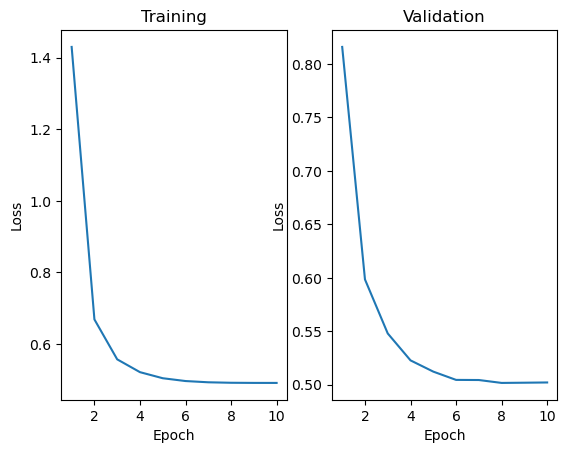

In [8]:

#plot 1:
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training')

#plot 2:
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), val_loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation')

plt.show()
# plt.savefig('image.png')

In [9]:
torch.save(model.state_dict(), './model/model_v1.pth')